In [5]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import numpy as np


In [95]:
CHECKPOINT_FOLDER = "/home/morg/students/gottesman3/knowledge-analysis-suite/performance_by_step/"
OUTPUT_FOLDER = "/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/subject_chunks"

In [96]:
SHARED_CHECKPOINT_FOLDER = "/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/outputs"
SHARED_OUTPUT_FOLDER = "/home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/shared_chunks"


In [8]:
def load_checkpoints(folder):
    checkpoints = {}
    for filename in os.listdir(folder):
        if filename.endswith(".json"):
            with open(os.path.join(folder, filename), "r") as f:
                data = json.load(f)
                checkpoint_name = os.path.splitext(filename)[0]
                checkpoints[checkpoint_name] = data
    return checkpoints

In [9]:
def extract_entity_data(checkpoint_data):
    records = []
    for entity_id, stats in checkpoint_data.items():
        questions = stats.get("questions", 0)
        correct = stats.get("correct", 0)
        occurences = stats.get("occurences", None)
        last_occurence = stats.get("last_occurence", None)

        if questions > 0:
            # accuracy = correct / questions
            records.append({
                "entity_id": entity_id,
               # "accuracy": accuracy,
                "questions": questions,
                "correct": correct,
                "occurences": occurences,
                "last_occurence": last_occurence
            })
    return pd.DataFrame(records)

In [59]:
import numpy as np
import pandas as pd

def bin_entities_by_field(df, field, bin_edges = None):
    filtered_df = df.loc[df[field].notna() & (df[field] > 0)].copy()

    try:
        if not bin_edges:
            max_val = filtered_df[field].max()
            bin_edges = np.linspace(0, max_val, num=11)  # 10 equal-width bins

        filtered_df["bin"] = pd.cut(
            filtered_df[field], bins=bin_edges, include_lowest=True
        )

        # Assertion: check values are inside their assigned bins
        assert all(
            filtered_df.apply(lambda row: row["bin"].left <= row[field] <= row["bin"].right, axis=1)
        ), f"Some values in '{field}' are not within their assigned bins."

    except ValueError as e:
        print(f"Could not bin '{field}'. Skipping. Reason: {e}")
        return

    # Group by bin - keep empty bins
    grouped = (
        filtered_df
        .groupby("bin", observed=False)
        .agg(
            total_questions=("questions", "sum"),
            total_correct=("correct", "sum"),
            entity_count=("entity_id", "count"),
            entities=("entity_id", lambda x: list(x))
        )
        .reset_index()
    )

    return grouped


In [107]:
def plot_accuracy_by_field(df, field, checkpoint_name, output_folder = None):
    
    if field == "last_occurence":
        grouped = bin_entities_by_field(df, field)
    else:
        grouped = bin_entities_by_field(df, field, bin_edges = [0, 10, 100, 1000, float("inf")])

    n = grouped['entities'].apply(len).sum()

    shared = output_folder and "shared" in output_folder

    grouped["accuracy"] = grouped.apply(
        lambda row: row["total_correct"] / row["total_questions"] if row["total_questions"] > 0 else 0, 
        axis=1
    )    
    grouped["bin_label"] = grouped["bin"].astype(str)
    grouped["checkpoint"] = checkpoint_name
    grouped["shared"] = shared
    grouped["performance_by"] = field

    return grouped

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="bin_label", y="accuracy", data=grouped)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{checkpoint_name}: Accuracy by {field} (n={n})")
    plt.ylabel("Accuracy (Total Correct / Total Questions)")
    plt.xlabel(f"{field.replace('_', ' ').title()}")
    if field == "last_occurence":
        plt.ylim(0, 0.3)
    else:
        plt.ylim(0, 1.11)

    plt.grid(True, linestyle="--", alpha=0.5)

    # Annotate entity counts
    for i, row in grouped.iterrows():
        ax.text(
            i,
            row["accuracy"] + 0.03,
            f'n={row["entity_count"]}',
            ha='center',
            va='bottom',
            fontsize=9
        )

    plt.tight_layout()

    if output_folder:
        plot_path = os.path.join(output_folder, f"{checkpoint_name}_binned_accuracy_by_{field}.png")
        plt.savefig(plot_path)
        print(f"Saved plot: {plot_path}")
    # else:
        # plt.show()
    
    plt.close()

In [ ]:
def plot_occurences_of_last_seen_entities(df, checkpoint_name, output_folder):
    # Filter entities with valid last_occurence and occurences

    shared = output_folder and "shared" in output_folder

    grouped_last_occurence = bin_entities_by_field(df, "last_occurence")
    max_bin = grouped_last_occurence["bin"].max()

    last_bin_entities = set(grouped_last_occurence.loc[grouped_last_occurence['bin'] == max_bin, 'entities'].values[0])


    filtered_df = df.loc[df["entity_id"].notna() & df["entity_id"].isin(last_bin_entities)]

    grouped_occurences = bin_entities_by_field(filtered_df, "occurences", bin_edges = [0, 10, 100, 1000, float("inf")])
    grouped_occurences["bin_label"] = grouped_occurences["bin"].astype(str)
    grouped_occurences["checkpoint"] = checkpoint_name
    grouped_occurences["shared"] = shared

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="bin_label", y="entity_count", data=grouped_occurences)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{checkpoint_name}: Occurence Bins of Last-Seen Entities")
    plt.ylabel("Entity Count")
    plt.xlabel("Occurences Bin")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

    plot_path = os.path.join(output_folder, f"{checkpoint_name}_last_seen_entities_by_occurences.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"Saved last-seen occurence bin plot: {plot_path}")
    return grouped_occurences[["checkpoint", "shared", "bin_label", "entity_count"]]

In [75]:
import matplotlib.pyplot as plt

def analyze_last_occurence_bin_entities(df):
    grouped_last_occurence = bin_entities_by_field(df, "last_occurence")
    max_bin = grouped_last_occurence["bin"].max()

    grouped_last_occurence["accuracy"] = grouped_last_occurence.apply(
        lambda row: row["total_correct"] / row["total_questions"] if row["total_questions"] > 0 else 0, 
        axis=1
    ) 

    print("before filtering")
    print(grouped_last_occurence[['bin', 'accuracy']].to_string(index=False))


    last_bin_entities = set(
        grouped_last_occurence.loc[
            grouped_last_occurence['bin'] == max_bin, 'entities'
        ].values[0]
    )

    correct_filtered_df = df.loc[
        df["entity_id"].notna() &
        df["entity_id"].isin(last_bin_entities)]

    grouped_occurences = bin_entities_by_field(
        correct_filtered_df,
        "occurences",
        bin_edges=[1, 10, 100, 1000, float("inf")]
    )
    grouped_occurences["accuracy"] = grouped_occurences.apply(
        lambda row: row["total_correct"] / row["total_questions"] if row["total_questions"] > 0 else 0, 
        axis=1
    ) 

    print("after filtering")
    print(grouped_occurences[['bin', 'accuracy']].to_string(index=False))

    # Total correct and questions across all filtered bins
    total_correct = grouped_occurences["total_correct"].sum()
    total_questions = grouped_occurences["total_questions"].sum()

    overall_filtered_accuracy = total_correct / total_questions

    print(f"Recomputed accuracy for last bin: {overall_filtered_accuracy:.5f}")


    
    grouped_occurences["bin_label"] = grouped_occurences["bin"].astype(str)
    return grouped_occurences

before filtering
             bin  accuracy
 (-0.001, 999.9]  0.007168
 (999.9, 1999.8]  0.010676
(1999.8, 2999.7]  0.006757
(2999.7, 3999.6]  0.008746
(3999.6, 4999.5]  0.002841
(4999.5, 5999.4]  0.007059
(5999.4, 6999.3]  0.010965
(6999.3, 7999.2]  0.013384
(7999.2, 8999.1]  0.008929
(8999.1, 9999.0]  0.060517
after filtering
            bin  accuracy
  (0.999, 10.0]  0.009934
  (10.0, 100.0]  0.040404
(100.0, 1000.0]  0.221311
  (1000.0, inf]  0.350877
Recomputed accuracy for last bin: 0.06052
before filtering
               bin  accuracy
  (-0.001, 1999.9]  0.009464
  (1999.9, 3999.8]  0.013812
  (3999.8, 5999.7]  0.010929
  (5999.7, 7999.6]  0.004785
  (7999.6, 9999.5]  0.008850
 (9999.5, 11999.4]  0.004032
(11999.4, 13999.3]  0.016923
(13999.3, 15999.2]  0.022697
(15999.2, 17999.1]  0.017154
(17999.1, 19999.0]  0.066239
after filtering
            bin  accuracy
  (0.999, 10.0]  0.010509
  (10.0, 100.0]  0.051576
(100.0, 1000.0]  0.222951
  (1000.0, inf]  0.380000
Recomputed accur

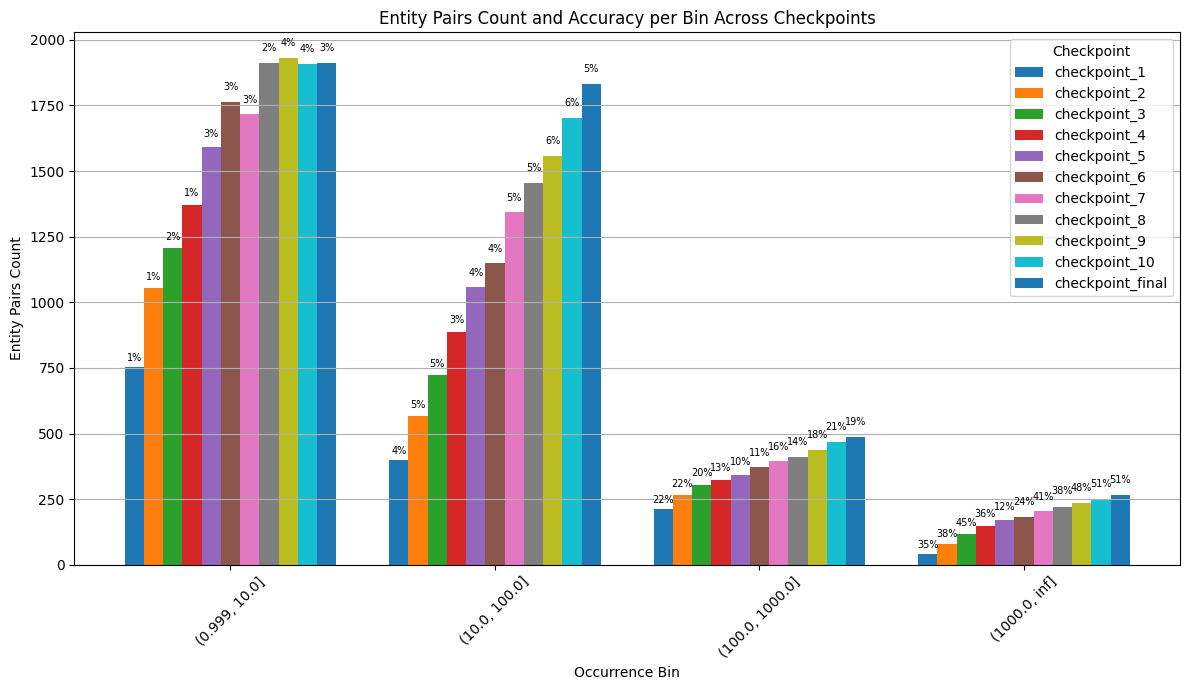

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for all checkpoints
all_grouped = []
checkpoint_names = []

checkpoints = load_checkpoints(SHARED_CHECKPOINT_FOLDER)
for checkpoint_name, checkpoint_data in checkpoints.items():
    df = extract_entity_data(checkpoint_data)
    grouped_occurences = analyze_last_occurence_bin_entities(df)
    grouped_occurences["checkpoint"] = checkpoint_name
    all_grouped.append(grouped_occurences)
    checkpoint_names.append(checkpoint_name)

# Get all bin labels (assumes all have same bins and order)
bins = all_grouped[0]["bin_label"].tolist()
num_bins = len(bins)
num_checkpoints = len(checkpoint_names)

# Set bar width and positions for grouped bars
bar_width = 0.8 / num_checkpoints
indices = np.arange(num_bins)

plt.figure(figsize=(12, 7))

for i, grouped_occurences in enumerate(all_grouped):
    # Bar positions for this checkpoint
    positions = indices - 0.4 + i * bar_width + bar_width/2

    plt.bar(
        positions,
        grouped_occurences["entity_count"],
        width=bar_width,
        label=checkpoint_names[i]
    )

    # Add accuracy text above each bar
    for pos, count, acc in zip(positions, grouped_occurences["entity_count"], grouped_occurences["accuracy"] * 100):
        plt.text(
            pos,
            count + max(grouped_occurences["entity_count"]) * 0.02,
            f"{acc:.0f}%",
            ha='center',
            va='bottom',
            fontsize=7,  # smaller font size here
            color='black'
        )


plt.xlabel("Occurrence Bin")
plt.ylabel("Entity Pairs Count")
plt.title("Entity Pairs Count and Accuracy per Bin Across Checkpoints")
plt.xticks(indices, bins, rotation=45)
plt.legend(title="Checkpoint")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [89]:
all_checkpoints_performance_checkpoints = []
checkpoints = load_checkpoints(CHECKPOINT_FOLDER)
for checkpoint_name, checkpoint_data in checkpoints.items():
    print(f"Processing checkpoint: {checkpoint_name}")        
    df = extract_entity_data(checkpoint_data)

    # analyze_last_occurence_bin_entities(df, checkpoint_name)
    
    # Create Plots by occurences
    occurences_accuracy_result = plot_accuracy_by_field(df, "occurences", checkpoint_name, OUTPUT_FOLDER)
    all_checkpoints_performance_checkpoints.append(occurences_accuracy_result)

    # Create Plots by last occurence
    last_occurence_results = plot_accuracy_by_field(df, "last_occurence", checkpoint_name, OUTPUT_FOLDER)
    all_checkpoints_performance_checkpoints.append(last_occurence_results)

    plot_occurences_of_last_seen_entities(df, checkpoint_name, SHARED_OUTPUT_FOLDER)
   


Processing checkpoint: checkpoint_2
Saved plot: /home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/subject_chunks/checkpoint_2_binned_accuracy_by_occurences.png
Saved plot: /home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/subject_chunks/checkpoint_2_binned_accuracy_by_last_occurence.png
Processing checkpoint: checkpoint_final
Saved plot: /home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/subject_chunks/checkpoint_final_binned_accuracy_by_occurences.png
Saved plot: /home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/subject_chunks/checkpoint_final_binned_accuracy_by_last_occurence.png
Processing checkpoint: checkpoint_1
Saved plot: /home/joberant/NLP_2425b/shirab6/knowledge-analysis-suite/OLMo-core/performance_by_step_plots/subject_chunks/checkpoint_1_binned_accuracy_by_occurences.png
Saved plot: /home/joberant/NLP_2

/tmp/ipykernel_1986903/3812758983.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


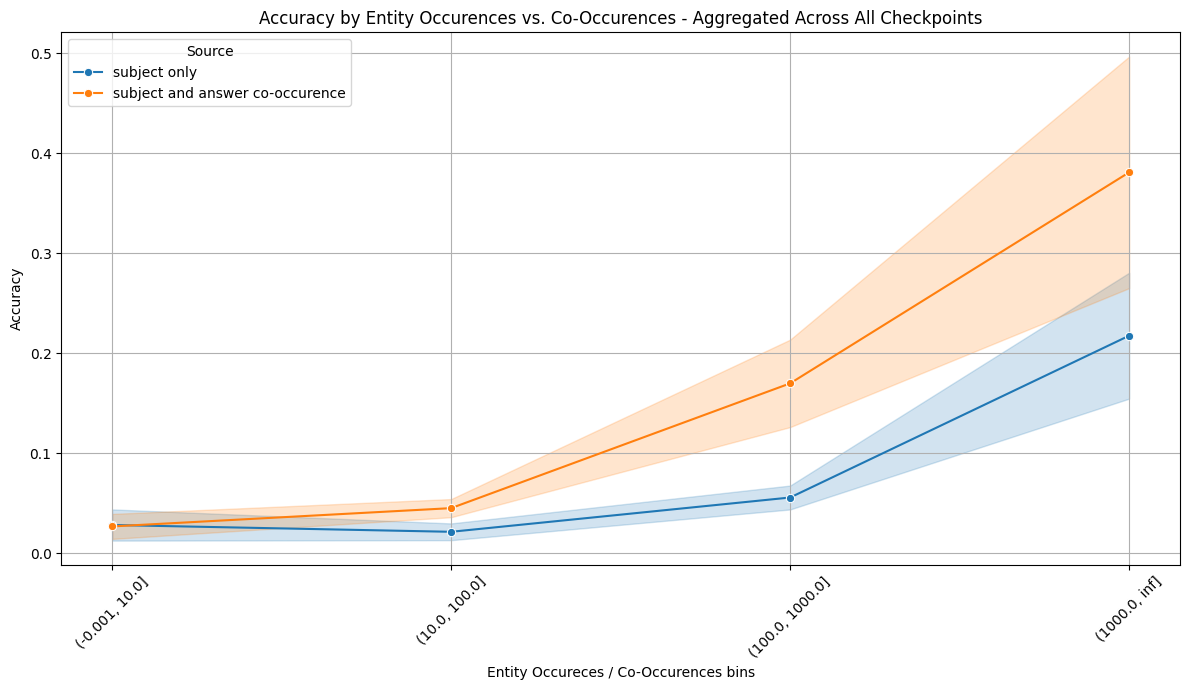

In [ ]:
# (1) Does the checkpoint succeed more on facts as it sees the subject and answer co-occur more frequently?

subject_checkpoints = load_checkpoints(CHECKPOINT_FOLDER)
shared_checkpoints = load_checkpoints(SHARED_CHECKPOINT_FOLDER)
shared_checkpoints

all_results = []

for checkpoint_name in subject_checkpoints.keys():
     subject_df = extract_entity_data(subject_checkpoints[checkpoint_name])
     shared_df = extract_entity_data(shared_checkpoints[checkpoint_name])

     subject_result = plot_accuracy_by_field(subject_df, "occurences", checkpoint_name, OUTPUT_FOLDER)

     subject_result["source"] = "subject only"
     subject_result["checkpoint"] = checkpoint_name 


     shared_result = plot_accuracy_by_field(shared_df, "occurences", checkpoint_name, SHARED_OUTPUT_FOLDER)
     shared_result["source"] = "subject and answer co-occurence"
     shared_result["checkpoint"] = checkpoint_name

     all_results.append(subject_result)
     all_results.append(shared_result)

# Concatenate all checkpoint results into one DataFrame
combined_all_df = pd.concat(all_results, ignore_index=True)

# Plot aggregated over all checkpoints, with confidence interval
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=combined_all_df,
    x="bin_label",
    y="accuracy",
    hue="source",  # subject vs shared
    ci="sd",       # or ci=95 for 95% confidence interval
    marker="o"
)

plt.xlabel("Entity Occureces / Co-Occurences bins")
plt.ylabel("Accuracy")
plt.title("Accuracy by Entity Occurences vs. Co-Occurences - Aggregated Across All Checkpoints")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.legend(title="Source")
plt.show()


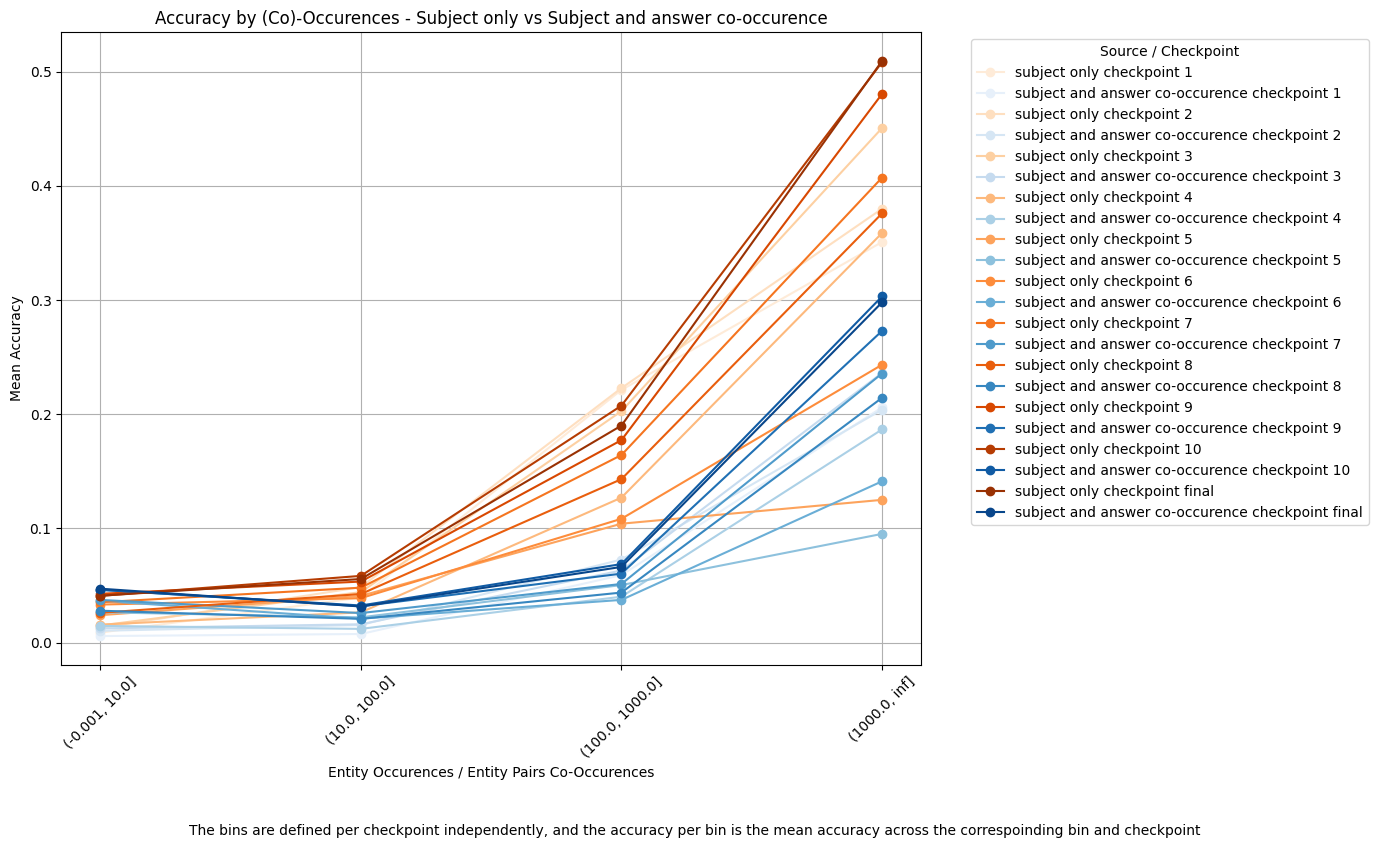

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

subject_checkpoints = load_checkpoints(SHARED_CHECKPOINT_FOLDER)
shared_checkpoints = load_checkpoints(CHECKPOINT_FOLDER)

all_results = []

for checkpoint_name in subject_checkpoints.keys():
    subject_df = extract_entity_data(subject_checkpoints[checkpoint_name])
    shared_df = extract_entity_data(shared_checkpoints[checkpoint_name])

    subject_result = plot_accuracy_by_field(subject_df, "occurences", checkpoint_name, OUTPUT_FOLDER)
    subject_result["source"] = "subject only"
    subject_result["checkpoint"] = checkpoint_name

    shared_result = plot_accuracy_by_field(shared_df, "occurences", checkpoint_name, SHARED_OUTPUT_FOLDER)
    shared_result["source"] = "subject and answer co-occurence"
    shared_result["checkpoint"] = checkpoint_name

    all_results.append(subject_result)
    all_results.append(shared_result)

combined_all_df = pd.concat(all_results, ignore_index=True)

# Optional: Ensure bin_label is ordered correctly
bin_order = sorted(combined_all_df["bin_label"].unique())
combined_all_df["bin_label"] = pd.Categorical(combined_all_df["bin_label"], categories=bin_order, ordered=True)

# Define custom palettes for shades of the same color per source
palette = {
    "subject only": sns.color_palette("Blues", n_colors=len(subject_checkpoints)),
    "subject and answer co-occurence": sns.color_palette("Oranges", n_colors=len(shared_checkpoints)),
}

# Map (source + checkpoint) to a color
combined_all_df["source_checkpoint"] = combined_all_df["source"] + "_" + combined_all_df["checkpoint"]

# Build custom color mapping
unique_keys = combined_all_df["source_checkpoint"].unique()
color_map = {}
subject_index = 0
shared_index = 0
for key in unique_keys:
    if "answer" in key:
        color_map[key] = palette["subject only"][subject_index % len(palette["subject only"])]
        subject_index += 1
    else:
        color_map[key] = palette["subject and answer co-occurence"][shared_index % len(palette["subject and answer co-occurence"])]
        shared_index += 1

# Plot
plt.figure(figsize=(14, 8))

for key in unique_keys:
    df = combined_all_df[combined_all_df["source_checkpoint"] == key]
    label = key.replace("_", " ")  # for cleaner legend
    plt.plot(df["bin_label"], df["accuracy"], marker='o', label=label, color=color_map[key])

plt.xlabel("Entity Occurences / Entity Pairs Co-Occurences")
plt.ylabel("Mean Accuracy")
plt.title("Accuracy by (Co)-Occurences - Subject only vs Subject and answer co-occurence")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Source / Checkpoint", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figtext(0.5, -0.05, "The bins are defined per checkpoint independently, and the accuracy per bin is the mean accuracy across the correspoinding bin and checkpoint", wrap=True,
            horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.show()


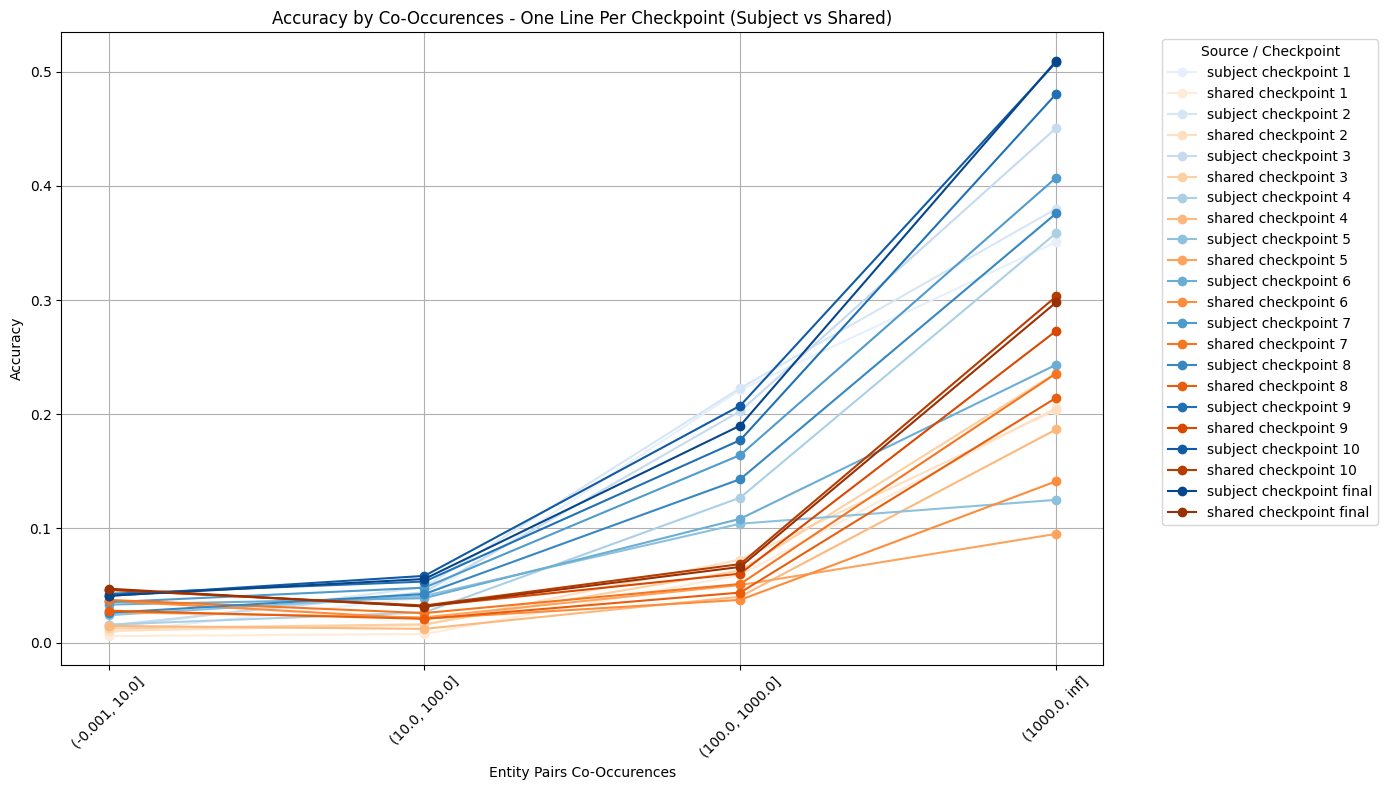

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

subject_checkpoints = load_checkpoints(SHARED_CHECKPOINT_FOLDER)
shared_checkpoints = load_checkpoints(CHECKPOINT_FOLDER)

all_results = []

for checkpoint_name in subject_checkpoints.keys():
    subject_df = extract_entity_data(subject_checkpoints[checkpoint_name])
    shared_df = extract_entity_data(shared_checkpoints[checkpoint_name])

    subject_result = plot_accuracy_by_field(subject_df, "occurences", checkpoint_name, OUTPUT_FOLDER)
    subject_result["source"] = "subject"
    subject_result["checkpoint"] = checkpoint_name

    shared_result = plot_accuracy_by_field(shared_df, "occurences", checkpoint_name, SHARED_OUTPUT_FOLDER)
    shared_result["source"] = "shared"
    shared_result["checkpoint"] = checkpoint_name

    all_results.append(subject_result)
    all_results.append(shared_result)

combined_all_df = pd.concat(all_results, ignore_index=True)

# Optional: Ensure bin_label is ordered correctly
bin_order = sorted(combined_all_df["bin_label"].unique())
combined_all_df["bin_label"] = pd.Categorical(combined_all_df["bin_label"], categories=bin_order, ordered=True)

# Define custom palettes for shades of the same color per source
palette = {
    "subject": sns.color_palette("Blues", n_colors=len(subject_checkpoints)),
    "shared": sns.color_palette("Oranges", n_colors=len(shared_checkpoints)),
}

# Map (source + checkpoint) to a color
combined_all_df["source_checkpoint"] = combined_all_df["source"] + "_" + combined_all_df["checkpoint"]

# Build custom color mapping
unique_keys = combined_all_df["source_checkpoint"].unique()
color_map = {}
subject_index = 0
shared_index = 0
for key in unique_keys:
    if key.startswith("subject"):
        color_map[key] = palette["subject"][subject_index % len(palette["subject"])]
        subject_index += 1
    else:
        color_map[key] = palette["shared"][shared_index % len(palette["shared"])]
        shared_index += 1

# Plot
plt.figure(figsize=(14, 8))

for key in unique_keys:
    df = combined_all_df[combined_all_df["source_checkpoint"] == key]
    label = key.replace("_", " ")  # for cleaner legend
    plt.plot(df["bin_label"], df["accuracy"], marker='o', label=label, color=color_map[key])

plt.xlabel("Entity Pairs Co-Occurences")
plt.ylabel("Accuracy")
plt.title("Accuracy by Co-Occurences - One Line Per Checkpoint (Subject vs Shared)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title="Source / Checkpoint", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
